## Setup

In [1]:
!pip uninstall tensorflow -yq
!pip install tensorflow-gpu>=2.0 gpustat matplotlib -Uq

In [0]:
from IPython.core.display import display, HTML

def export_html(result, max_activation):
    output = ""
    max_activation += 1e-8
    
    for line in result:
        word, activation = line
            
        if activation>0:
            activation = activation/max_activation
            colour = str(int(255 - activation*255))
            tag_open = "<span style='background-color: rgb(255,"+colour+","+colour+");'>"
            
        else:
            activation = -1 * activation/max_activation
            colour = str(int(255 - activation*255))
            tag_open = "<span style='background-color: rgb("+colour+","+colour+",255);'>"
            
        tag_close = "</span>"
        tag = " ".join([tag_open, word, tag_close])
        
        output = output + tag
        
    output = output + ""
    
    return output

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.compat.v2 as tf
from tensorflow.keras import layers

# Exploring RNNs

In [4]:
!gpustat

5b7872e3969e         Tue Dec 31 16:44:17 2019  418.67
[0] Tesla P4         | 51'C,   0 % |     0 /  7611 MB |


In [0]:
seq_len = 128
model_dim = 16

In [0]:
text = "Nvidia Corporation is more commonly referred to as Nvidia. It was formerly stylized as nVidia on products from the mid 90s to early 2000s. Nvidia is an American technology company incorporated in Delaware and based in Santa Clara, California. Nvidia designs graphics processing units for the gaming and professional markets, as well as system on a chip units for the mobile computing and automotive market. Nvidia's primary GPU product line, labeled GeForce, is in direct competition with Advanced Micro Devices Radeon products. Nvidia expanded its presence in the gaming industry with its handheld Shield Portable, Shield Tablet, and Shield Android TV. Since 2014, Nvidia has diversified its business focusing on four markets: gaming, professional visualization, data centers, and auto. Nvidia is also now focused on artificial intelligence. In addition to GPU manufacturing, Nvidia provides parallel processing capabilities to researchers and scientists that allow them to efficiently run high performance applications. They are deployed in supercomputing sites around the world. "

In [7]:
text = text.lower().replace(" ", "_").replace(",", "")
text_len = len(text)
print("Text length:", text_len)

vocab = sorted(set(text))
vocab_size = len(vocab) + 1
print("Vocab size:", vocab_size)

tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True, char_level=True)
tokenizer.fit_on_texts([text])

tokens = tokenizer.texts_to_sequences([text])[0]

x_train = []
y_train = []

for i in range(text_len-seq_len):
    x_train.append(tokens[i:i+seq_len])
    y_train.append(tokens[i+seq_len])

Text length: 1071
Vocab size: 34


In [8]:
l_input = layers.Input(shape=(seq_len,))
l_embed = layers.Embedding(vocab_size, 16)(l_input)
l_rnn_1, state_h, state_c = layers.LSTM(model_dim,
                                        return_state=True,
                                        return_sequences=True)(l_embed)
l_rnn_1 = layers.Activation("relu")(l_rnn_1)
preds = tf.keras.layers.Dense(vocab_size,
                              activation="softmax")(l_rnn_1[:,-1,:])

model = tf.keras.models.Model(inputs=l_input, outputs=preds)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 128, 16)           544       
_________________________________________________________________
lstm (LSTM)                  [(None, 128, 16), (None,  2112      
_________________________________________________________________
activation (Activation)      (None, 128, 16)           0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 34)                578       
Total params: 3,234
Trainable params: 3,234
Non-trainable params: 0
___________________________________________________________

Phase 1:
Train on 943 samples
Epoch 1/10
943/943 - 9s - loss: 3.0667 - acc: 0.1389
Epoch 2/10
943/943 - 6s - loss: 2.9325 - acc: 0.1453
Epoch 3/10
943/943 - 6s - loss: 2.8926 - acc: 0.1453
Epoch 4/10
943/943 - 6s - loss: 2.8439 - acc: 0.1485
Epoch 5/10
943/943 - 6s - loss: 2.7917 - acc: 0.1718
Epoch 6/10
943/943 - 6s - loss: 2.7341 - acc: 0.2089
Epoch 7/10
943/943 - 6s - loss: 2.6725 - acc: 0.2566
Epoch 8/10
943/943 - 6s - loss: 2.6187 - acc: 0.2694
Epoch 9/10
943/943 - 6s - loss: 2.5734 - acc: 0.2715
Epoch 10/10
943/943 - 6s - loss: 2.5356 - acc: 0.2694
943/1 - 0s - loss: 2.5634 - acc: 0.2778
 - Loss: 2.4988732044668995
 - Acc:  0.27783668


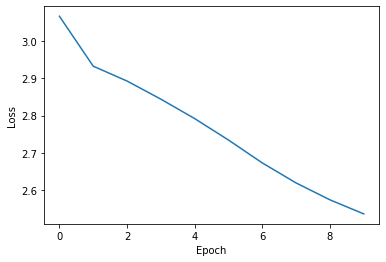

In [9]:
print("Phase 1:")

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["acc"])

history = model.fit(x_train, y_train, epochs=10,
                    batch_size=1, shuffle=False,
                    callbacks=[], verbose=2)

scores = model.evaluate(x_train, y_train, batch_size=32, verbose=2)

print(" - Loss:", scores[0])
print(" - Acc: ", scores[1])

plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Phase 2:
Train on 943 samples
Epoch 1/50
943/943 - 8s - loss: 1.7833 - acc: 0.4634
Epoch 2/50
943/943 - 6s - loss: 1.7461 - acc: 0.4655
Epoch 3/50
943/943 - 6s - loss: 1.7135 - acc: 0.4867
Epoch 4/50
943/943 - 6s - loss: 1.6760 - acc: 0.4952
Epoch 5/50
943/943 - 6s - loss: 1.6578 - acc: 0.4793
Epoch 6/50
943/943 - 6s - loss: 1.6874 - acc: 0.4867
Epoch 7/50
943/943 - 6s - loss: 1.6859 - acc: 0.4889
Epoch 8/50
943/943 - 6s - loss: 1.6951 - acc: 0.4846
Epoch 9/50
943/943 - 6s - loss: 1.7064 - acc: 0.4942
Epoch 10/50
943/943 - 6s - loss: 1.6912 - acc: 0.4952
Epoch 11/50
943/943 - 6s - loss: 1.7735 - acc: 0.4655
Epoch 12/50
943/943 - 6s - loss: 1.6772 - acc: 0.4889
Epoch 13/50
943/943 - 6s - loss: 1.6728 - acc: 0.4973
Epoch 14/50
943/943 - 6s - loss: 1.6584 - acc: 0.4942
Epoch 15/50
943/943 - 6s - loss: 1.6996 - acc: 0.4698
Epoch 16/50
943/943 - 6s - loss: 1.6670 - acc: 0.4878
Epoch 17/50
943/943 - 6s - loss: 1.6974 - acc: 0.5058
Epoch 18/50
943/943 - 7s - loss: 1.6670 - acc: 0.4942
Epoch 1

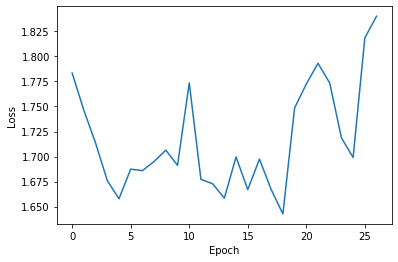

In [12]:
print("Phase 2:")

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["acc"])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='acc',
                                              restore_best_weights=True,
                                              patience=10)

history = model.fit(x_train, y_train, epochs=50,
                    batch_size=1, shuffle=True,
                    callbacks=[early_stop], verbose=2)

scores = model.evaluate(x_train, y_train, batch_size=32, verbose=2)

print(" - Loss:", scores[0])
print(" - Acc: ", scores[1])

plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [0]:
lstm_act = tf.keras.models.Model(inputs=l_input, outputs=[l_rnn_1, state_h, state_c])

In [0]:
def infer_activations(n):
    input_text = text[n:n+seq_len]
    input_tokens = tokenizer.texts_to_sequences([input_text])
    pred = np.argmax(model.predict(input_tokens)[0])
    pred = tokenizer.sequences_to_texts([[pred]])
    print("Input:", input_text)
    print("Truth:", text[n+seq_len], "Pred:", pred)
    print("\nActivations")
    activations, h, c = lstm_act.predict([input_tokens])
    activations = activations[0]
    for dim in range(model_dim):
        act_t_list = [a[dim] for a in activations]
        act_t_max = max(act_t_list)
        result = zip(input_text, act_t_list)
        output = export_html(result, act_t_max)
        if dim < 10:
            dim = "0"+str(dim)
        else:
            dim = str(dim)
        display(HTML(dim + " : " + output))
    print("")

def infer_h_c(start_n, show_h=False, show_c=True):
    end_n = start_n + seq_len + 1
    h_list, c_list = [], []
    for n in range(start_n, end_n):
        input_text = text[n-seq_len:n]
        input_tokens = tokenizer.texts_to_sequences([input_text])
        activations, h, c = lstm_act.predict([input_tokens])
        h, c = h[0], c[0]
        h_list.append(h)
        c_list.append(c)
    if show_h:
        print("Hidden State")
        for dim in range(model_dim):
            act_t_list = [a[dim] for a in h_list]
            act_t_max = max(act_t_list)
            result = zip(input_text, act_t_list)
            output = export_html(result, act_t_max)
            if dim < 10:
                dim = "0"+str(dim)
            else:
                dim = str(dim)
            display(HTML(dim + " : " + output))
        print("")
    if show_c:
        print("Cell State")
        for dim in range(model_dim):
            act_t_list = [a[dim] for a in c_list]
            act_t_max = max(act_t_list)
            result = zip(input_text, act_t_list)
            output = export_html(result, act_t_max)
            if dim < 10:
                dim = "0"+str(dim)
            else:
                dim = str(dim)
            display(HTML(dim + " : " + output))
        print("")

In [15]:
n = 150
infer_activations(n)
infer_h_c(n)

Input: n_american_technology_company_incorporated_in_delaware_and_based_in_santa_clara_california._nvidia_designs_graphics_processing_u
Truth: n Pred: ['n']

Activations



Cell State


In [0]:
def plot_dependency(n):
    input_text = text[n:n+seq_len]
    input_tokens = tokenizer.texts_to_sequences([input_text])
    label = [text[n+seq_len]]
    label = tokenizer.texts_to_sequences([label])
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    x = tf.convert_to_tensor(input_tokens, dtype=tf.float32)
    y_true = tf.convert_to_tensor(label, dtype=tf.float32)

    with tf.GradientTape() as g:
        g.watch(x)
        y = model(x)
        loss_value = loss(y_true, y)
        grads = g.gradient(loss_value, model.trainable_weights)
    input_grads = grads[0].values.numpy()
    input_grads = np.sum(input_grads**2, axis=-1)

    truncate = seq_len//4
    result = zip(input_text[-truncate:], input_grads[-truncate:])
    output = export_html(result, max(input_grads))
    output = output + " &nbsp; -> &nbsp; " + text[n+seq_len]
    output = "<code>" + output + "</code>"
    display(HTML(output))

In [51]:
plot_dependency(153)

In [52]:
plot_dependency(114)
plot_dependency(115)
plot_dependency(116)
plot_dependency(117)
plot_dependency(118)
plot_dependency(119)
plot_dependency(120)
plot_dependency(121)